In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time

In [39]:
# img = cv2.imread('../islands-300.jpeg')
# img = cv2.imread('../gnome_media_floppy.png')/255.0
img = cv2.imread('../print.jpg')
# img = cv2.imread('../Волков АК.jpg')


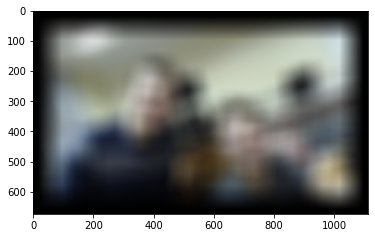

In [40]:
plt.imshow(blurs[80][:,:,::-1])

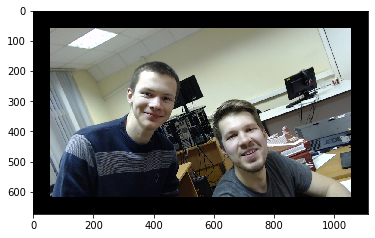

In [34]:
plt.imshow(img[:,:,::-1])

In [41]:
class Stroke():
    def __init__(self, image, dispersion, amount, speed, ttl, wide, blurs):
        image_size = image.shape[:2]
        self.dispersion = dispersion
        x = np.random.randint(0, image_size[1], 1)
        y = np.random.randint(0, image_size[0], 1)
        self.center = np.concatenate([x, y], axis=0).astype(np.float)
        self.offset = np.zeros((2, amount), dtype=np.float)
        
        self.particles_angle = np.random.uniform(0, 2 * np.pi, amount)
        self.particles_radius = np.fabs(np.random.normal(0, dispersion*2, amount))
        
        self.offset[0] = np.cos(self.particles_angle) * self.particles_radius
        self.offset[1] = np.sin(self.particles_angle) * self.particles_radius
        
        self.angle = np.random.uniform(0, 2 * np.pi)
        self.rotation = np.random.uniform(-np.pi/60, np.pi/60)
        self.color = image[y[0], x[0]].astype(np.float64)
        self.speed = np.random.normal(speed, speed/3, 1)
        self.status = 'running'
        self.ttl = np.random.normal(ttl)
        self.ttl = 0.5 if self.ttl < 0.5 else self.ttl
        self.wide = wide
        self.blurs = blurs
        
        
    def get_mean_color(self, image, x, y):
        if 0 < x < image.shape[1] and 0 < y < image.shape[0]:
            return self.blurs[self.dispersion][int(y), int(x)]
        else:
            return self.color
        
        
    def update(self, image):  
        self.last_center = self.center.copy()
        self.last_offset = self.offset.copy()
        self.angle += self.rotation
        self.particles_angle += self.rotation
        
        self.center[0] += np.cos(self.angle) * self.speed
        self.center[1] += np.sin(self.angle) * self.speed
        self.offset[0] = np.cos(self.particles_angle) * self.particles_radius
        self.offset[1] = np.sin(self.particles_angle) * self.particles_radius
        
        mean_color = self.get_mean_color(image, self.center[0], self.center[1])
        self.color = self.color - (self.color - mean_color)/2
        self.ttl -= np.random.uniform(0, 0.05)
        if self.ttl <= 0:
            self.status = 'deleted'
            
        if np.random.randint(0, 30, 1) == 0:
            self.rotation = np.random.uniform(-np.pi/60, np.pi/60)
        
        
    def draw(self, image):
        last_positions = (self.last_center.reshape(2, 1) + [self.last_offset[0], self.last_offset[1]]).T.reshape(-1, 1, 2)
        positions = (self.center.reshape(2, 1) + [self.offset[0], self.offset[1]]).T.reshape(-1, 1, 2)
        points = np.concatenate([last_positions, positions], axis=1).astype(np.int32)
        cv2.polylines(image, points, False, self.color, self.wide)   
        

In [51]:
class Drawer:
    def __init__(self, image):
        img = image.copy()
        max_size = 1000
        min_size = 300
        img_max_size = max(img.shape[:2])
        img_min_size = min(img.shape[:2])
        if img_min_size < min_size and img_max_size > max_size:
            print('Select image with aspect ratio less then 3')
        H, W = img.shape[0], img.shape[1]

        # firstly we would increase minimal side if needed
        if H < W:
            if H < min_size:
                img = cv2.resize(img, (int(W * min_size / H), min_size))
        else:
            if W < min_size:
                img = cv2.resize(img, (min_size, int(H * min_size / W)))

        # secondly we would decrease max side if needed 
        if H > W:
            if H > max_size:
                img = cv2.resize(img, (int(W * max_size / H), max_size))
        else:
            if W > max_size:
                img = cv2.resize(img, (max_size, int(H * max_size / W)))

        H, W = img.shape[0], img.shape[1]
        padding = int(W * 0.1 if H > W else H * 0.1)
        zeros = np.zeros((H + padding * 2, W + padding * 2, 3), dtype=np.uint8)
        zeros[padding: padding + H, padding: padding + W] = img
        self.img = zeros
        self.mask_img = np.zeros(self.img.shape, dtype=np.uint8)

        self.blurs = dict()
        for i in range(1, 100):
            self.blurs[i] = cv2.blur(self.img, (i, i))
            
            
    def draw_video(self):
        max_image_size = max(self.img.shape[:2])
        max_strokes_base = int(200 * (max_image_size / 1150))
        max_strokes_base = 2 if max_strokes_base < 2 else max_strokes_base
        strokes_amount_base = int(15 * ((max_image_size / 600) ** 0.5))
        strokes_amount_base = 1 if strokes_amount_base < 1 else strokes_amount_base
        min_dispersion_base = int(8 * (max_image_size / 700))
        min_dispersion_base = 1 if min_dispersion_base < 1 else min_dispersion_base
        max_dispersion_base = int(20 * (max_image_size / 700))
        max_dispersion_base = 2 if max_dispersion_base < 2 else max_dispersion_base
        min_amount_base = int(20 * (max_image_size / 700))
        min_amount_base = 1 if min_amount_base < 1 else min_amount_base
        max_amount_base = int(50 * (max_image_size / 1150))
        max_amount_base = 2 if max_amount_base < 2 else max_amount_base
        speed_base = int(10 * (max_image_size / 1150))
        speed_base = 1 if speed_base < 1 else speed_base
        ttl_base = 3.14
        wide_base = int(8 * ((max_image_size / 1150) ** 0.3))
        wide_base = 2 if wide_base < 2 else wide_base

        strokes_amount = strokes_amount_base
        min_dispersion = min_dispersion_base
        max_dispersion = max_dispersion_base
        min_amount = min_amount_base
        max_amount = max_amount_base
        speed = speed_base
        ttl = ttl_base
        wide = wide_base

        strokes = [Stroke(self.img, 
                          dispersion=np.random.randint(min_dispersion, max_dispersion), 
                          amount=np.random.randint(min_amount, max_amount),
                          speed=speed,
                          ttl=ttl,
                          wide=wide,
                          blurs=self.blurs) for _ in range(strokes_amount)]
        total_img_value = self.img.sum()
        error = 1
        iterations = 0
        max_iterations = 3000
        fourcc = cv2.VideoWriter_fourcc(*'MP4V')
        vid = cv2.VideoWriter('temp.mp4', fourcc, 100, (self.img.shape[1], self.img.shape[0]) )

        start = time.time()

        for iterations in range(max_iterations):
            strokes = [st for st in strokes if st.status != 'deleted']
            for _ in range(strokes_amount - len(strokes)):
                strokes.append(Stroke(self.img, 
                                      np.random.randint(int(min_dispersion), int(max_dispersion)), 
                                      np.random.randint(int(min_amount), int(max_amount)),
                                      speed=speed,
                                      ttl=ttl,
                                      wide=wide,
                                      blurs=self.blurs))

            for st in strokes:
                st.update(self.img)
                st.draw(self.mask_img)

            if iterations % 10 == 0 and iterations > 300:
                iteration_progress = iterations / max_iterations
                if iteration_progress > 1:
                    iteration_progress = 1
                min_dispersion = min_dispersion_base - ((min_dispersion_base - 1) * iteration_progress)
                max_dispersion = max_dispersion_base - ((max_dispersion_base - 2) * iteration_progress)
                min_amount = min_amount_base - ((min_amount_base - 1) * (iteration_progress ** 0.5))
                max_amount = max_amount_base - ((max_amount_base - 5) * (iteration_progress ** 0.5))
                strokes_amount = int(strokes_amount_base + (max_strokes_base - strokes_amount_base) * (iteration_progress ** 8))
                ttl = ttl_base - ((ttl_base - 1) * iteration_progress)
                wide = int(wide_base - ((wide_base - 1) * (iteration_progress ** 0.5)))
        #         print(iterations, iteration_progress)

            vid.write(self.mask_img)
        #     cv2.imshow('BlindArtist', mask_img)
        #     key = cv2.waitKey(1)
        #     if key == 27:      # esc
        #         break


        while len(strokes) > 0:
            strokes = [st for st in strokes if st.status != 'deleted']
            for st in strokes:
                st.update(self.img)
                st.draw(self.mask_img)

            vid.write(self.mask_img)
        #     cv2.imshow('BlindArtist', mask_img)
        #     key = cv2.waitKey(1)
        #     if key == 27:      # esc
        #         break


        for _ in range(300):
            vid.write(self.mask_img)
        #     cv2.imshow('BlindArtist', mask_img)
        #     key = cv2.waitKey(1)
        #     if key == 27:      # esc
        #         break

        end = time.time()
        print(f'total time: {end-start}')

        vid.release()
        cv2.destroyAllWindows()

In [54]:
img = cv2.imread('../Pictures/FH18.png')
drawer = Drawer(img)

In [53]:
drawer.draw_video()

total time: 25.09922194480896


In [ ]:
# 64.2, 48, 51 - with float
# 25.9, 26, 26 - with uint8

In [47]:
%%time
!ffmpeg -i temp.mp4 -vcodec h264 -r 60 -y temp_compressed.mp4 -hide_banner -loglevel warning

Past duration 0.799995 too large
CPU times: user 126 ms, sys: 40.5 ms, total: 166 ms
Wall time: 9 s
